#Mount and Load Dataset from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_file_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/archive.zip"
extracted_dir = "/content/dataset"
!mkdir -p "{extracted_dir}"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
!ls "{extracted_dir}"

bangla-mnist  labels.csv


In [3]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from sklearn import svm
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Load Dataset

In [4]:
labels_df = pd.read_csv('dataset/labels.csv')
# Remove id column
labels_df = labels_df.drop(labels_df.columns[0], axis=1)

labels_df.head()

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


#Visualize Dataset

In [5]:
labels_df.shape

(72045, 2)

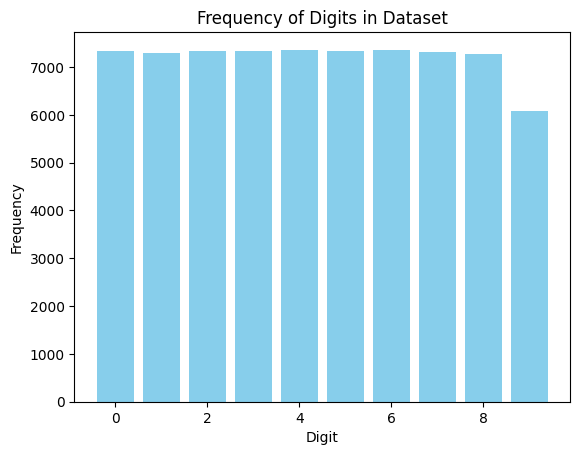

In [6]:
digit_counts = labels_df['digit'].value_counts().sort_index()

# Bar chart
plt.bar(digit_counts.index, digit_counts.values, color='skyblue')
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Frequency of Digits in Dataset')
plt.show()

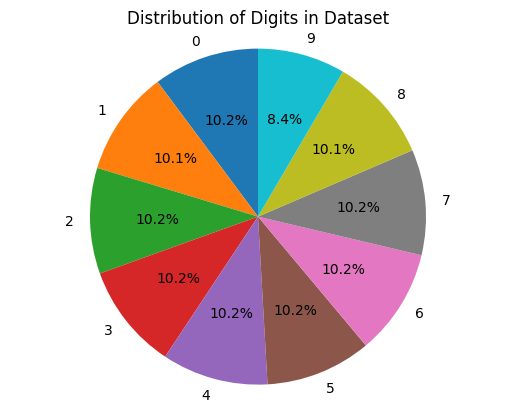

In [7]:
plt.pie(digit_counts, labels=digit_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Digits in Dataset')
plt.show()

#Check for Null values

In [8]:
labels_df.isnull().sum()

filename    0
digit       0
dtype: int64

#Image Preprocessing

In [9]:

image_folder = 'dataset/bangla-mnist/labeled'


image_list = []
label_list = []


for idx, row in labels_df.iterrows():

    if idx % 2000 == 0:
        print(idx)

    # The following condition is run if we want to ignore
    # the white background images and take the images with
    # black background only
    if idx < 55267:
        continue

    img_name = os.path.join(image_folder, row['filename'])

    # Load Image
    img = cv2.imread(os.path.join(image_folder, row['filename']), cv2.IMREAD_GRAYSCALE)

    # Convert to Binary
    threshold_value = 0.8 * 255
    _, binary_img = cv2.threshold(img, threshold_value, 1, cv2.THRESH_BINARY)

    # Invert if background white
    if binary_img[0, 0] == 1:
        binary_img = 1 - binary_img

    # Crop to 20x20
    non_zero_points = cv2.findNonZero(binary_img)
    x, y, w, h = cv2.boundingRect(non_zero_points)

    cropped_img = binary_img[y:y+h, x:x+w]
    if len(cropped_img) == 0:
        continue
    resized_img = cv2.resize(cropped_img, (20, 20))
    padded_img = np.pad(resized_img, ((4, 4)), mode='constant', constant_values=0)

    image_list.append(padded_img)

    # Label
    label = row['digit']
    label_list.append(label)


image_list = np.array(image_list)
label_list = np.array(label_list)

# Split the dataset into training and testing sets
train_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(image_list, label_list, train_size=train_size, shuffle=True)



0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000
64000
66000
68000
70000
72000


In [10]:


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13422, 28, 28)
(3356, 28, 28)
(13422,)
(3356,)


1  4  2  1  4  3  9  2  

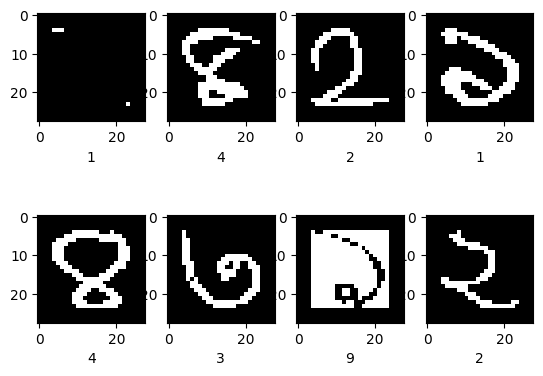

In [11]:
import matplotlib.pyplot as plt



for i in range(8):
  # print(dataset[i][1].shape)
  print(y_train[i], end = "  ")
  plt.subplot(2, 4, i+1)
  plt.imshow(X_train[i], cmap = 'gray')
  plt.xlabel(f'{y_train[i]}')

plt.show()

#SVM

In [12]:
# Flatten
X_train_flatten = X_train.reshape((X_train.shape[0], -1))
X_test_flatten = X_test.reshape((X_test.shape[0], -1))


#batch size
batch_size = 5000

# Linear SVM
svm_model = svm.SVC(kernel='linear')

# Train
for i in range(0, X_train_flatten.shape[0], batch_size):
    X_batch = X_train_flatten[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    svm_model.fit(X_batch, y_batch)


# Predictions
y_pred = np.concatenate([svm_model.predict(X_test_flatten[i:i+batch_size]) for i in range(0, X_test_flatten.shape[0], batch_size)])

# Evaluate the performance
svm_accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {svm_accuracy}')


Accuracy: 0.8468414779499404


In [13]:
from sklearn.metrics import accuracy_score, classification_report

report=classification_report(y_test, y_pred)
print('Classification Report')
print(report)

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       356
           1       0.79      0.87      0.83       339
           2       0.84      0.91      0.87       335
           3       0.70      0.77      0.74       311
           4       0.86      0.86      0.86       343
           5       0.89      0.83      0.86       330
           6       0.81      0.72      0.77       348
           7       0.95      0.95      0.95       363
           8       0.91      0.95      0.93       319
           9       0.80      0.65      0.72       312

    accuracy                           0.85      3356
   macro avg       0.85      0.84      0.84      3356
weighted avg       0.85      0.85      0.85      3356



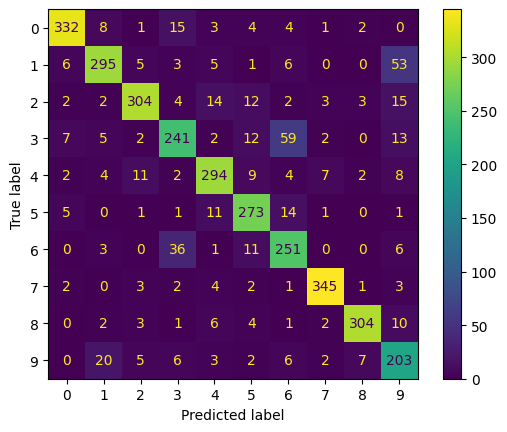

In [14]:
uni_vals = labels_df['digit'].unique().sort()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_pred, y_test, labels = uni_vals)

cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = uni_vals)
cm_disp.plot()

#Softmax

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers



# Softmax
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(10, activation='softmax')
])

# Compile
model.compile(optimizer=optimizers.SGD(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=10)

#Evaluate
test_loss, softmax_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {softmax_accuracy}')

Epoch 1/10
420/420 [==============================] - 2s 3ms/step - loss: 2.1953 - accuracy: 0.1815
Epoch 2/10
420/420 [==============================] - 1s 3ms/step - loss: 1.8405 - accuracy: 0.4516
Epoch 3/10
420/420 [==============================] - 1s 3ms/step - loss: 1.5847 - accuracy: 0.6026
Epoch 4/10
420/420 [==============================] - 3s 6ms/step - loss: 1.3965 - accuracy: 0.6769
Epoch 5/10
420/420 [==============================] - 1s 3ms/step - loss: 1.2557 - accuracy: 0.7220
Epoch 6/10
420/420 [==============================] - 1s 2ms/step - loss: 1.1481 - accuracy: 0.7482
Epoch 7/10
420/420 [==============================] - 1s 2ms/step - loss: 1.0639 - accuracy: 0.7659
Epoch 8/10
420/420 [==============================] - 1s 2ms/step - loss: 0.9966 - accuracy: 0.7771
Epoch 9/10
420/420 [==============================] - 1s 2ms/step - loss: 0.9417 - accuracy: 0.7871
Epoch 10/10
420/420 [==============================] - 1s 2ms/step - loss: 0.8962 - accuracy: 0.7938

In [16]:
from sklearn.metrics import accuracy_score, classification_report
y_pred_prob = model.predict(X_test)
y_pred = tf.argmax(y_pred_prob, axis=1)
report=classification_report(y_test, y_pred)
print('Classification Report')
print(report)
softmax_accuracy = np.mean(np.equal(y_pred, y_test))

105/105 [==============================] - 0s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       356
           1       0.75      0.82      0.78       339
           2       0.86      0.76      0.81       335
           3       0.71      0.67      0.69       311
           4       0.77      0.87      0.82       343
           5       0.74      0.82      0.78       330
           6       0.73      0.66      0.69       348
           7       0.91      0.87      0.89       363
           8       0.84      0.92      0.88       319
           9       0.73      0.64      0.69       312

    accuracy                           0.79      3356
   macro avg       0.79      0.79      0.79      3356
weighted avg       0.80      0.79      0.79      3356



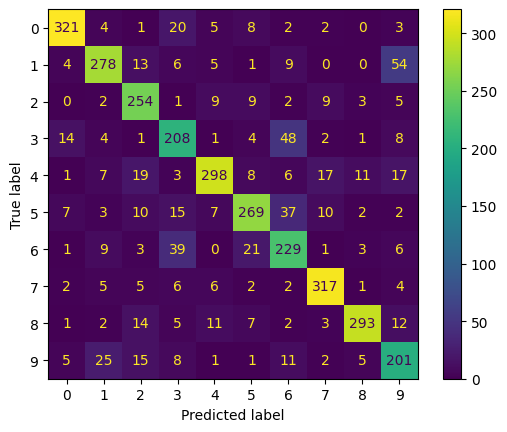

In [17]:
uni_vals = labels_df['digit'].unique().sort()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_pred, y_test, labels = uni_vals)

cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = uni_vals)
cm_disp.plot()

#Neural Network

In [18]:
# Simple Neural Network
model = models.Sequential()

# Flatten layer (for 28x28 images)
model.add(layers.Flatten(input_shape=(28, 28, 1)))

# Fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=10)

# Evaluate
test_loss, nn_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {nn_accuracy}')


Epoch 1/10
420/420 [==============================] - 3s 5ms/step - loss: 0.5445 - accuracy: 0.8373
Epoch 2/10
420/420 [==============================] - 3s 6ms/step - loss: 0.2811 - accuracy: 0.9172
Epoch 3/10
420/420 [==============================] - 3s 8ms/step - loss: 0.2014 - accuracy: 0.9408
Epoch 4/10
420/420 [==============================] - 3s 7ms/step - loss: 0.1432 - accuracy: 0.9582
Epoch 5/10
420/420 [==============================] - 2s 4ms/step - loss: 0.1072 - accuracy: 0.9700
Epoch 6/10
420/420 [==============================] - 2s 4ms/step - loss: 0.0760 - accuracy: 0.9782
Epoch 7/10
420/420 [==============================] - 2s 4ms/step - loss: 0.0552 - accuracy: 0.9847
Epoch 8/10
420/420 [==============================] - 2s 4ms/step - loss: 0.0387 - accuracy: 0.9908
Epoch 9/10
420/420 [==============================] - 2s 6ms/step - loss: 0.0334 - accuracy: 0.9917
Epoch 10/10
420/420 [==============================] - 3s 7ms/step - loss: 0.0234 - accuracy: 0.9951

#CNN

In [19]:
# CNN
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten layer
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=10)

# Evaluate
test_loss, cnn_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {cnn_accuracy}')


Epoch 1/10
420/420 [==============================] - 16s 34ms/step - loss: 0.4075 - accuracy: 0.8742
Epoch 2/10
420/420 [==============================] - 14s 34ms/step - loss: 0.1528 - accuracy: 0.9535
Epoch 3/10
420/420 [==============================] - 17s 40ms/step - loss: 0.1147 - accuracy: 0.9653
Epoch 4/10
420/420 [==============================] - 22s 53ms/step - loss: 0.0842 - accuracy: 0.9747
Epoch 5/10
420/420 [==============================] - 30s 72ms/step - loss: 0.0685 - accuracy: 0.9790
Epoch 6/10
420/420 [==============================] - 17s 41ms/step - loss: 0.0520 - accuracy: 0.9834
Epoch 7/10
420/420 [==============================] - 12s 29ms/step - loss: 0.0425 - accuracy: 0.9856
Epoch 8/10
420/420 [==============================] - 14s 34ms/step - loss: 0.0337 - accuracy: 0.9886
Epoch 9/10
420/420 [==============================] - 14s 33ms/step - loss: 0.0255 - accuracy: 0.9914
Epoch 10/10
420/420 [==============================] - 20s 47ms/step - loss: 0.024

In [20]:
from sklearn.metrics import accuracy_score, classification_report
y_pred_prob = model.predict(X_test)
y_pred = tf.argmax(y_pred_prob, axis=1)
report=classification_report(y_test, y_pred)
print('Classification Report')
print(report)

105/105 [==============================] - 1s 9ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       356
           1       0.96      0.95      0.96       339
           2       0.96      0.99      0.97       335
           3       0.95      0.96      0.96       311
           4       0.97      0.97      0.97       343
           5       0.97      0.96      0.97       330
           6       0.99      0.96      0.97       348
           7       0.98      0.97      0.98       363
           8       0.95      0.99      0.97       319
           9       0.96      0.96      0.96       312

    accuracy                           0.97      3356
   macro avg       0.97      0.97      0.97      3356
weighted avg       0.97      0.97      0.97      3356



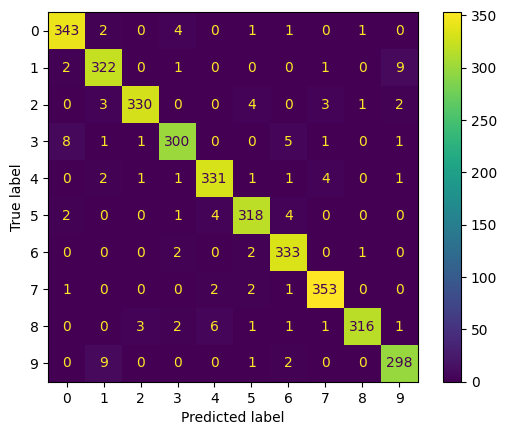

In [21]:
uni_vals = labels_df['digit'].unique().sort()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_pred, y_test, labels = uni_vals)

cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = uni_vals)
cm_disp.plot()

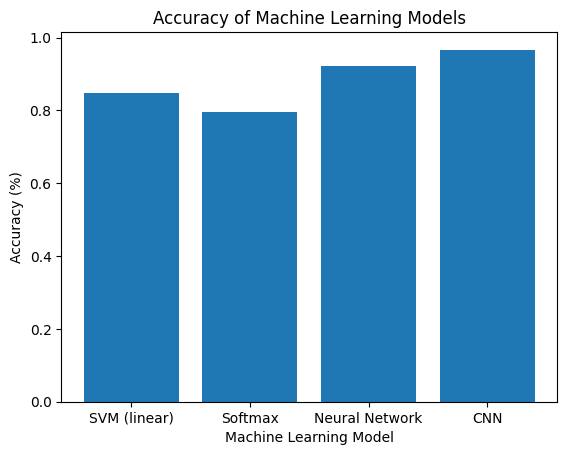

In [22]:
import matplotlib.pyplot as plt

models = ['SVM (linear)', 'Softmax', 'Neural Network', 'CNN']

accuracies = [svm_accuracy, softmax_accuracy, nn_accuracy, cnn_accuracy]

# Bar Chart
plt.bar(models, accuracies)

# Title
plt.title('Accuracy of Machine Learning Models')

# Axis Labels
plt.xlabel('Machine Learning Model')
plt.ylabel('Accuracy (%)')


plt.show()